In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
import nltk

In [3]:
dataset = pd.read_csv('bbc-text.csv')
dataset.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


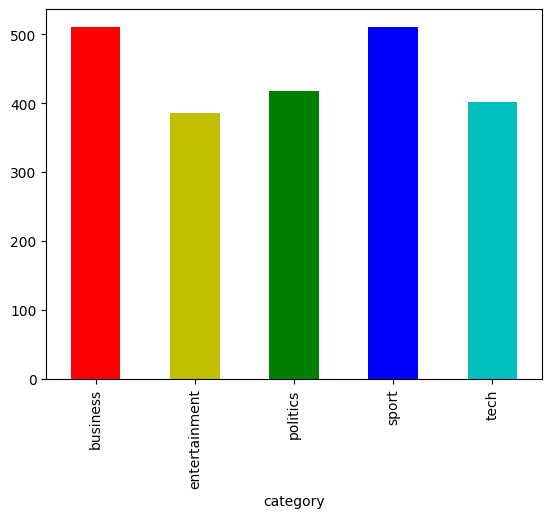

In [4]:
dataset.groupby('category').text.count().plot.bar(ylim=0, color=['r', 'y', 'g', 'b', 'c'])
plt.show()

In [5]:
stemmer = PorterStemmer()
words = stopwords.words("english")
dataset['cleaned'] = dataset['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [6]:
dataset.head()

,category,text,cleaned
0,tech,tv future in the hands of viewers with home th...,tv futur hand viewer home theatr system plasma...
1,business,worldcom boss left books alone former worldc...,worldcom boss left book alon former worldcom b...
2,sport,tigers wary of farrell gamble leicester say ...,tiger wari farrel gambl leicest say rush make ...
3,sport,yeading face newcastle in fa cup premiership s...,yead face newcastl fa cup premiership side new...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelv raid box offic ocean twelv crime c...


In [7]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(dataset['cleaned']).toarray()
final_features.shape

(2225, 29637)

In [8]:
from sklearn.linear_model import LogisticRegression
X = dataset['cleaned']
Y = dataset['category']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', LogisticRegression(random_state=0))])

model = pipeline.fit(X_train, y_train)
with open('LogisticRegression.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))

               precision    recall  f1-score   support

     business       0.95      0.99      0.97       122
entertainment       0.97      0.99      0.98       100
     politics       1.00      0.93      0.96       101
        sport       0.98      1.00      0.99       127
         tech       0.99      0.95      0.97       107

     accuracy                           0.97       557
    macro avg       0.98      0.97      0.97       557
 weighted avg       0.98      0.97      0.97       557



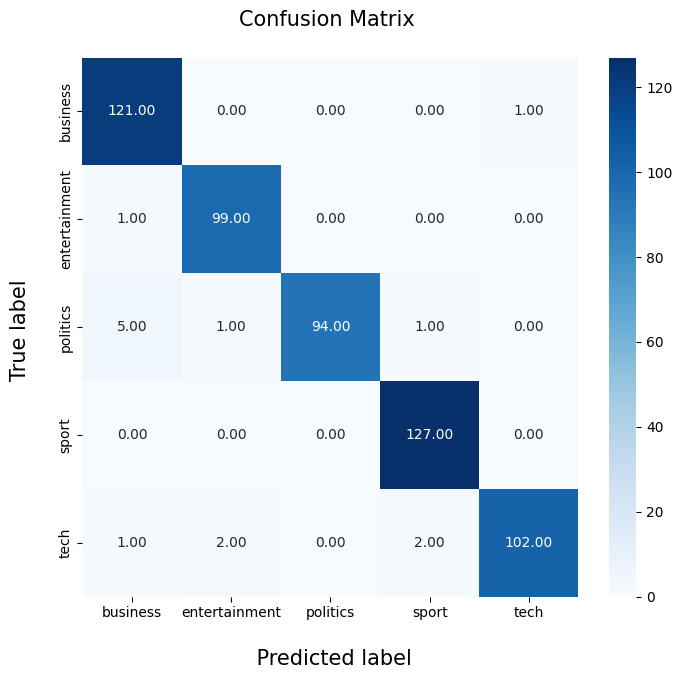

In [9]:
#confution matrtix
target_names = ["business", "entertainment", "politics", "sport", "tech"]
cm = confusion_matrix(ytest, model.predict(X_test))

fig, ax = plt.subplots(figsize=(8,7))
plt.title("Confusion Matrix \n", fontsize = 15)
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap=plt.cm.Blues)
plt.ylabel('True label \n', fontsize=15)
plt.xlabel('\n Predicted label', fontsize=15)
plt.show()

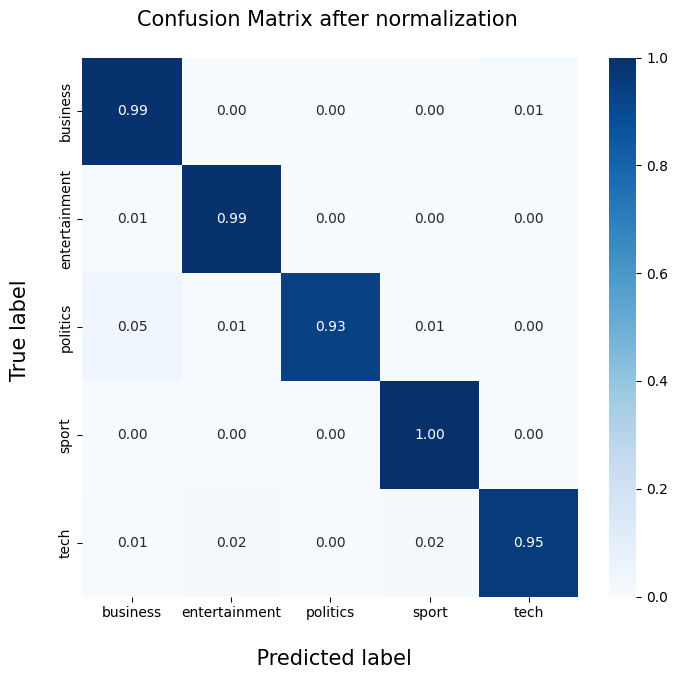

In [10]:
# confution matrix after normalization
target_names = ["business", "entertainment", "politics", "sport", "tech"]
cm = confusion_matrix(ytest, model.predict(X_test))

#Normalise
cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,7))
plt.title("Confusion Matrix after normalization \n", fontsize = 15)
sns.heatmap(cm_n, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap=plt.cm.Blues)
plt.ylabel('True label \n', fontsize=15)
plt.xlabel('\n Predicted label', fontsize=15)
plt.show()